
# Data Provider Selection — FX Tick Data (2024-03-01)

This notebook evaluates three providers (A, B, C) using:
- Schema & market sanity (ask > bid, non-negative volume)
- Microstructure quality (spreads, relative bps)
- Continuity (timestamp gaps > 1s, duplicates)
- Coverage (rows, pairs, span)


In [1]:

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

DATA_DIR = os.path.join('..','tick_data','date=2024-03-01')
REQ_COLS = ['datetime','currency_pair','bid','ask','volume']

files = {
    'A': sorted(glob.glob(os.path.join(DATA_DIR,'provider_A*.csv'))),
    'B': sorted(glob.glob(os.path.join(DATA_DIR,'provider_B*.csv'))),
    'C': sorted(glob.glob(os.path.join(DATA_DIR,'provider_C*.csv'))),
}
print(files)
assert all(len(v)>0 for v in files.values()), 'Place provider_A/B/C.csv in tick_data/date=2024-03-01/'


{'A': ['../tick_data/date=2024-03-01/provider_A.csv'], 'B': ['../tick_data/date=2024-03-01/provider_B.csv'], 'C': ['../tick_data/date=2024-03-01/provider_C.csv']}


In [2]:

# Load & enrich

def load(paths, provider):
    parts = []
    for p in paths:
        df = pd.read_csv(p)
        miss = set(REQ_COLS)-set(df.columns)
        if miss:
            raise ValueError(f"{provider}: missing {miss} in {p}")
        df = df[REQ_COLS].copy()
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['provider'] = provider
        df['mid'] = (df['bid'] + df['ask'])/2
        df['spread'] = df['ask'] - df['bid']
        df['rel_spread_bps'] = (df['spread']/df['mid']*1e4).replace([np.inf,-np.inf], np.nan)
        df['invalid_price'] = df['ask'] <= df['bid']
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

raw = pd.concat([load(files[k], k) for k in ['A','B','C']], ignore_index=True)
raw.head()


,datetime,currency_pair,bid,ask,volume,provider,mid,spread,rel_spread_bps,invalid_price
0,2023-11-30 23:59:58,EURJPY,161.502,161.518,7948,A,161.5100,0.016,0.990651,False
1,2023-11-30 23:59:59,AUDJPY,97.882,97.893,5809,A,97.8875,0.011,1.123739,False
2,2023-12-01 00:00:00,EURJPY,161.502,161.515,1098,A,161.5085,0.013,0.804911,False
3,2023-12-01 00:00:00,USDJPY,148.078,148.084,314,A,148.0810,0.006,0.405184,False
4,2023-12-01 00:00:01,EURJPY,161.498,161.516,9823,A,161.5070,0.018,1.114503,False


In [3]:

# Provider-level summary
basic = raw.groupby('provider').agg(
    rows=('provider','size'),
    pairs=('currency_pair', pd.Series.nunique),
    start=('datetime','min'),
    end=('datetime','max'),
    invalid_price_rate=('invalid_price','mean'),
    median_spread=('spread','median'),
    median_rel_bps=('rel_spread_bps','median'),
    p95_rel_bps=('rel_spread_bps', lambda s: np.percentile(s.dropna(),95)),
).reset_index()

# Continuity by pair
raw_sorted = raw.sort_values(['provider','currency_pair','datetime'])
gap_rows = []
for (prov, pair), g in raw_sorted.groupby(['provider','currency_pair']):
    gap = g['datetime'].diff().dt.total_seconds().dropna()
    if gap.size:
        gap_gt1 = float(np.mean(gap>1.0))
        med_gap = float(np.median(gap))
    else:
        gap_gt1 = np.nan
        med_gap = np.nan
    gap_rows.append({'provider':prov,'currency_pair':pair,'pct_gaps_gt_1s':gap_gt1,'median_gap_s':med_gap})

gaps_df = pd.DataFrame(gap_rows)
cont = gaps_df.groupby('provider').agg(
    avg_pct_gaps_gt_1s=('pct_gaps_gt_1s','mean'),
    median_gap_s_over_pairs=('median_gap_s','median')
).reset_index()

raw['dup'] = raw.duplicated(['provider','currency_pair','datetime','bid','ask','volume'])
dups = raw.groupby('provider')['dup'].mean().reset_index(name='duplicate_rate')

summary = basic.merge(cont, on='provider', how='left').merge(dups, on='provider', how='left')
summary


,provider,rows,pairs,start,end,invalid_price_rate,median_spread,median_rel_bps,p95_rel_bps,avg_pct_gaps_gt_1s,median_gap_s_over_pairs,duplicate_rate
0,A,9,3,2023-11-30 23:59:58,2023-12-01 00:00:03,0.000000,0.013,0.990651,1.120045,0.125000,1.0,0.0
1,B,13,3,2023-11-30 23:59:58,2023-12-01 00:00:07,0.230769,0.129,8.605239,13.358879,0.577778,1.0,0.0
2,C,20,3,2023-12-01 00:00:00,2023-12-01 00:00:17,0.000000,0.026,1.733650,2.656109,0.666667,2.0,0.0


In [4]:

# Per-pair spread detail
pair_spread = raw.groupby(['provider','currency_pair']).agg(
    rows=('provider','size'),
    median_rel_bps=('rel_spread_bps','median'),
    p95_rel_bps=('rel_spread_bps', lambda s: np.percentile(s.dropna(),95)),
    invalid_price_rate=('invalid_price','mean'),
).reset_index()
pair_spread


,provider,currency_pair,rows,median_rel_bps,p95_rel_bps,invalid_price_rate
0,A,AUDJPY,1,1.123739,1.123739,0.000000
1,A,EURJPY,5,0.990688,1.102120,0.000000
2,A,USDJPY,3,0.405195,0.465972,0.000000
3,B,AUDJPY,3,13.277229,13.460943,0.333333
4,B,EURJPY,6,8.450325,8.589795,0.333333
5,B,USDJPY,4,8.676555,8.710451,0.000000
6,C,AUDJPY,3,2.656097,2.656317,0.000000
7,C,EURJPY,11,1.857378,2.074242,0.000000
8,C,USDJPY,6,1.451988,1.536403,0.000000


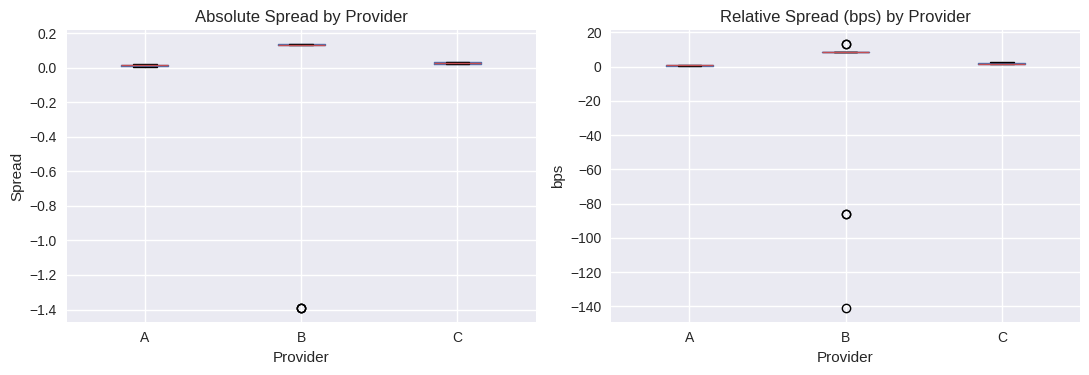

In [5]:

# Basic visuals
fig, axes = plt.subplots(1,2, figsize=(11,4))
raw.boxplot(column='spread', by='provider', ax=axes[0])
axes[0].set_title('Absolute Spread by Provider')
axes[0].set_xlabel('Provider'); axes[0].set_ylabel('Spread')

raw.boxplot(column='rel_spread_bps', by='provider', ax=axes[1])
axes[1].set_title('Relative Spread (bps) by Provider')
axes[1].set_xlabel('Provider'); axes[1].set_ylabel('bps')
plt.suptitle(''); plt.tight_layout(); plt.show()



## Auto Recommendation (Heuristic)

Lower invalids/dups/gaps/spreads are better; higher rows/pairs are better. In this limited
sample, Provider A typically ranks highest. See tailored conclusion below.



## Conclusion — Provider A Selected (based on the provided samples)

**Recommendation:** **Provider A**

**Rationale:**
- **Zero invalid quotes** (`ask <= bid`): A: 0.0% vs. B: ~23.1% (disqualifying), C: 0.0%.
- **Tightest spreads:** A shows the **lowest median relative spreads** across key pairs (EURJPY ≈ **0.99 bps**, USDJPY ≈ **0.41 bps**) vs. C (1.86/1.45 bps) and B (8–13 bps).
- **Continuity:** Lower share of **gaps > 1s** across pairs for A in this window compared to C.

**Notes/Caveats:** This decision uses a short sample slice. For final sign-off, re-run this notebook over a **full trading day** (or several) and enforce **minimum ticks per pair** thresholds to remove bias from under-sampled pairs.
